In [1]:
import paddle
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print("PaddlePaddle is compiled with CUDA:", paddle.is_compiled_with_cuda())
print("PaddlePaddle is using GPU:", paddle.device.get_device())

True
NVIDIA GeForce RTX 3060 Laptop GPU
PaddlePaddle is compiled with CUDA: True
PaddlePaddle is using GPU: gpu:0


In [2]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

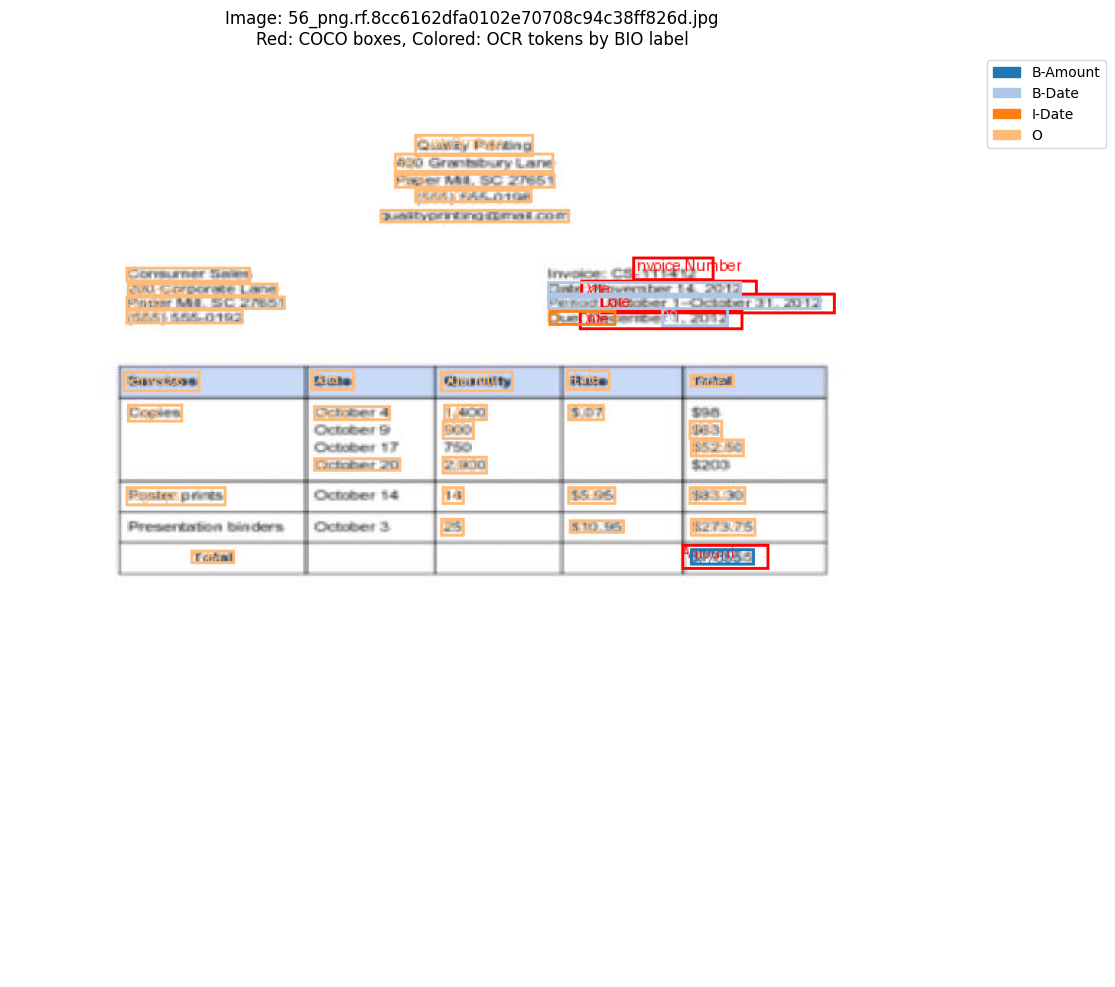

In [3]:
import os
import json
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURATION ---
train_img_dir = "../dataset/train"
coco_ann_path = "../dataset/train/_annotations.coco.json"
jsonl_path = "../layoutlmv3_train.jsonl"

# --- LOAD COCO ANNOTATIONS ---
with open(coco_ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)
img_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
filename_to_img_id = {v: k for k, v in img_id_to_filename.items()}
img_id_to_anns = {}
for ann in coco["annotations"]:
    img_id_to_anns.setdefault(ann["image_id"], []).append(ann)
cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

# --- LOAD JSONL (OCR tokens and BIO labels) ---
with open(jsonl_path, "r", encoding="utf-8") as f:
    jsonl_examples = [json.loads(line) for line in f]

# --- PICK RANDOM EXAMPLE ---
example = random.choice(jsonl_examples)
img_filename = example["file_name"] if "file_name" in example else example.get("image_path", None)
if img_filename is None:
    # Try to infer from tokens or fallback
    img_filename = os.path.basename(example["image"]) if "image" in example else None
assert img_filename is not None, "Could not determine image filename from JSONL example."

img_path = os.path.join(train_img_dir, img_filename)
img_id = filename_to_img_id.get(img_filename)
assert img_id is not None, f"Image id not found for {img_filename}"

# --- LOAD IMAGE ---
image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(image)

# --- PLOT COCO ANNOTATION BOXES ---
anns = img_id_to_anns.get(img_id, [])
for ann in anns:
    x, y, w, h = ann["bbox"]
    rect = [x, y, x + w, y + h]
    draw.rectangle(rect, outline="red", width=2)
    cat_name = cat_id_to_name.get(ann["category_id"], "unknown")
    draw.text((x, y), cat_name, fill="red")

# --- PLOT OCR TOKENS COLORED BY BIO LABEL ---
tokens = example["tokens"]
bboxes = example["bboxes"]
labels = example["labels"]

# Define a color map for BIO labels
import matplotlib
unique_labels = sorted(set(labels))
label_colors = {l: matplotlib.colors.to_hex(plt.cm.tab20(i % 20)) for i, l in enumerate(unique_labels)}

for token, bbox, label in zip(tokens, bboxes, labels):
    # bbox is [x0, y0, x1, y1] in 0-1000 normalized coordinates
    x0, y0, x1, y1 = [int(v * image.width / 1000) if i % 2 == 0 else int(v * image.height / 1000) for i, v in enumerate(bbox)]
    color = label_colors[label]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
    draw.text((x0, y0), token, fill=color)

# --- SHOW LEGEND ---
plt.figure(figsize=(12, 12))
plt.imshow(image)
legend_patches = [patches.Patch(color=label_colors[l], label=l) for l in unique_labels]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.title(f"Image: {img_filename}\nRed: COCO boxes, Colored: OCR tokens by BIO label")
plt.show()

In [4]:
from collections import defaultdict, Counter

def compute_region_coverage(jsonl_path, coco_path):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        jsonl_examples = [json.loads(line) for line in f]

    with open(coco_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    img_id_to_anns = defaultdict(list)
    for ann in coco["annotations"]:
        img_id_to_anns[ann["image_id"]].append(ann)

    filename_to_img_id = {img["file_name"]: img["id"] for img in coco["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

    total_regions = 0
    total_missed = 0

    print("Region Coverage Report")
    print("="*60)
    for ex in jsonl_examples:
        fname = ex["file_name"]
        labels = ex["labels"]
        img_id = filename_to_img_id[fname]
        anns = img_id_to_anns.get(img_id, [])
        coco_labels = [cat_id_to_name[a["category_id"]] for a in anns]
        tagged_cats = set(l.split("-")[-1] for l in labels if l != "O" and "-" in l)
        missed = set(coco_labels) - tagged_cats

        total_regions += len(coco_labels)
        total_missed += len(missed)

        percent_missed = (len(missed) / len(coco_labels) * 100) if coco_labels else 0
        print(f"Image: {fname}")
        print(f"  - COCO regions: {len(coco_labels)}")
        print(f"  - Missed regions: {len(missed)} ({percent_missed:.1f}%) {missed if missed else ''}")

    overall_miss_rate = (total_missed / total_regions * 100) if total_regions else 0
    print("="*60)
    print(f"Overall missed regions: {total_missed} / {total_regions} ({overall_miss_rate:.1f}%)")

# Example usage:
compute_region_coverage(
    jsonl_path="../layoutlmv3_train.jsonl",
    coco_path="../dataset/train/_annotations.coco.json"
)

Region Coverage Report
Image: 219_jpg.rf.f5d1587c6b4d3417f86eb1588623e817.jpg
  - COCO regions: 3
  - Missed regions: 0 (0.0%) 
Image: 105_jpg.rf.fb1226959cd48b65c04fe8e7e04990a7.jpg
  - COCO regions: 3
  - Missed regions: 2 (66.7%) {'Amount', 'Invoice Number'}
Image: 156_jpg.rf.fec69d73caaaf2750050e9806369cad0.jpg
  - COCO regions: 3
  - Missed regions: 0 (0.0%) 
Image: 166_jpg.rf.feeb4f228f0ddf822f378a05f729f900.jpg
  - COCO regions: 3
  - Missed regions: 0 (0.0%) 
Image: 118_jpg.rf.f5df35eabe52612a78c8864a8d198d0d.jpg
  - COCO regions: 3
  - Missed regions: 1 (33.3%) {'Invoice Number'}
Image: 188_jpg.rf.f8f8f850f9fb606809b4bcd1601a06b9.jpg
  - COCO regions: 3
  - Missed regions: 1 (33.3%) {'Date'}
Image: 248_jpg.rf.faa9796830eda1d2a0a3daab6bd13074.jpg
  - COCO regions: 3
  - Missed regions: 0 (0.0%) 
Image: 186_jpg.rf.f9765d528595499a81d2212fa828d52e.jpg
  - COCO regions: 3
  - Missed regions: 0 (0.0%) 
Image: 177_jpg.rf.fb3dea0e88b201ba2498be2a526fef81.jpg
  - COCO regions: 3
  - M

# LayoutLMv3 Training Script for Invoice Data Extraction

In [5]:
from datasets import load_dataset
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor, TrainingArguments, Trainer
import torch

# Load train and validation splits from their respective JSONL files
data_files = {
    "train": "../layoutlmv3_train.jsonl",
    "validation": "../layoutlmv3_valid.jsonl"
}
dataset = load_dataset("json", data_files=data_files)
print(f"Train samples: {len(dataset['train'])}, Validation samples: {len(dataset['validation'])}")

# Build label list from your data
labels = sorted({label for example in dataset['train'] for label in example['labels']})
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

# Load processor and model
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 249 examples [00:00, 6512.94 examples/s]
Generating train split: 249 examples [00:00, 6512.94 examples/s]s/s]
Generating validation split: 25 examples [00:00, 7341.43 examples/s]
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If 

Train samples: 249, Validation samples: 25


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Verify bounding box format and normalization
# Each bbox should be [x0, y0, x1, y1] and all values in 0-1000

def check_bbox_format(dataset):
    sample = dataset["train"][0]
    bboxes = sample["bboxes"]
    for bbox in bboxes[:5]:  # check first 5 bboxes
        assert len(bbox) == 4, f"Bbox should have 4 elements, got {bbox}"
        assert all(0 <= v <= 1000 for v in bbox), f"Bbox values out of range: {bbox}"
    print("Sample bboxes (first 5):", bboxes[:5])
    print("Bounding box format and normalization look correct.")

check_bbox_format(dataset)


Sample bboxes (first 5): [[432, 4, 536, 27], [365, 31, 606, 65], [432, 65, 541, 88], [410, 82, 597, 106], [400, 101, 575, 125]]
Bounding box format and normalization look correct.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 249
    })
    validation: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 25
    })
})

In [ ]:
import numpy as np
# Preprocessing function for the dataset
def preprocess(example):
    encoding = processor.tokenizer(
        example["tokens"],
        boxes=example["bboxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    # Pad labels to max_length
    labels = [label2id[l] for l in example["labels"]]
    labels = labels + [-100] * (512 - len(labels))
    encoding["labels"] = torch.tensor(labels)
    # Print keys for debugging
    # print(f"Encoding keys: {list(encoding.keys())}")
    return encoding

# Apply preprocessing
dataset = dataset.map(preprocess, batched=False)
# Print a sample to check keys
print(dataset["train"][0])

Map:  25%|██▍       | 62/249 [00:00<00:00, 608.05 examples/s]

Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_id

Map:  86%|████████▌ | 213/249 [00:00<00:00, 602.07 examples/s]

Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_id

Map: 100%|██████████| 25/25 [00:00<00:00, 279.10 examples/s]

Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_id

In [9]:
# Set format for PyTorch
dataset.set_format(type="torch", columns=["input_ids", "bbox", "attention_mask", "labels"])

In [17]:
from datasets import load_metric

# Define compute_metrics for sequence labeling (BIO tagging)
metric = load_metric("seqeval")

label_list = labels  # already sorted and used for label2id/id2label

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    # Prefix all metrics with 'eval_' to match Trainer expectations
    return {
        "eval_precision": results["overall_precision"],
        "eval_recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "eval_accuracy": results["overall_accuracy"]
    }

C:\Users\Haythem\AppData\Local\Temp\ipykernel_12680\3245775408.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code whic

In [18]:
# Training arguments
args = TrainingArguments(
    output_dir="./layoutlmv3-invoice",
    per_device_train_batch_size=2,
    num_train_epochs=5,
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,  # Required for non-loss metrics
    seed=42,
    fp16=True  # Set to True if your GPU supports it, else set to False
)

In [20]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics 
)

# Start training
trainer.train()

  0%|          | 0/625 [00:00<?, ?it/s]c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  2%|▏         | 10/625 [00:03<03:34,  2.87it/s] 

{'loss': 0.2665, 'grad_norm': 1.1513619422912598, 'learning_rate': 4.92e-05, 'epoch': 0.08}


  3%|▎         | 20/625 [00:07<03:49,  2.64it/s] 

{'loss': 0.2441, 'grad_norm': 2.5690484046936035, 'learning_rate': 4.8400000000000004e-05, 'epoch': 0.16}


  5%|▍         | 30/625 [00:11<03:40,  2.70it/s] 

{'loss': 0.2482, 'grad_norm': 2.331148862838745, 'learning_rate': 4.76e-05, 'epoch': 0.24}


  6%|▋         | 40/625 [00:15<03:41,  2.64it/s] 

{'loss': 0.2452, 'grad_norm': 1.713728666305542, 'learning_rate': 4.6800000000000006e-05, 'epoch': 0.32}


  8%|▊         | 50/625 [00:19<03:33,  2.69it/s] 

{'loss': 0.2805, 'grad_norm': 3.111135721206665, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.4}


 10%|▉         | 60/625 [00:23<03:47,  2.49it/s] 

{'loss': 0.2571, 'grad_norm': 3.2059264183044434, 'learning_rate': 4.52e-05, 'epoch': 0.48}


 11%|█         | 70/625 [00:26<03:18,  2.80it/s] 

{'loss': 0.2103, 'grad_norm': 3.2265007495880127, 'learning_rate': 4.44e-05, 'epoch': 0.56}


 13%|█▎        | 80/625 [00:30<03:16,  2.77it/s] 

{'loss': 0.2472, 'grad_norm': 1.8302685022354126, 'learning_rate': 4.36e-05, 'epoch': 0.64}


 14%|█▍        | 90/625 [00:34<03:19,  2.68it/s] 

{'loss': 0.301, 'grad_norm': 1.6091506481170654, 'learning_rate': 4.2800000000000004e-05, 'epoch': 0.72}


 16%|█▌        | 100/625 [00:38<03:26,  2.54it/s]

{'loss': 0.3118, 'grad_norm': 3.2474093437194824, 'learning_rate': 4.2e-05, 'epoch': 0.8}






c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 16%|█▌        | 100/625 [00:39<03:26,  2.54it/s]
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

{'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.9253867151956324, 'eval_loss': 0.3256051540374756, 'eval_runtime': 0.7089, 'eval_samples_per_second': 35.266, 'eval_steps_per_second': 5.642, 'epoch': 0.8}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 18%|█▊        | 110/625 [00:45<03:44,  2.30it/s]

{'loss': 0.3443, 'grad_norm': 2.2114601135253906, 'learning_rate': 4.12e-05, 'epoch': 0.88}


 19%|█▉        | 120/625 [00:49<03:25,  2.45it/s]

{'loss': 0.3551, 'grad_norm': 2.523256778717041, 'learning_rate': 4.0400000000000006e-05, 'epoch': 0.96}


 21%|██        | 130/625 [00:52<02:57,  2.78it/s]

{'loss': 0.2768, 'grad_norm': 1.4627509117126465, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}


 22%|██▏       | 140/625 [00:56<03:02,  2.65it/s]

{'loss': 0.2662, 'grad_norm': 1.0592678785324097, 'learning_rate': 3.88e-05, 'epoch': 1.12}


 24%|██▍       | 150/625 [01:00<03:00,  2.64it/s]

{'loss': 0.2919, 'grad_norm': 3.5117201805114746, 'learning_rate': 3.8e-05, 'epoch': 1.2}


 26%|██▌       | 160/625 [01:04<02:54,  2.66it/s]

{'loss': 0.2723, 'grad_norm': 2.9407529830932617, 'learning_rate': 3.72e-05, 'epoch': 1.28}


 27%|██▋       | 170/625 [01:08<02:48,  2.70it/s]

{'loss': 0.2609, 'grad_norm': 1.2337050437927246, 'learning_rate': 3.6400000000000004e-05, 'epoch': 1.36}


 29%|██▉       | 180/625 [01:12<03:00,  2.46it/s]

{'loss': 0.2932, 'grad_norm': 1.8362351655960083, 'learning_rate': 3.56e-05, 'epoch': 1.44}


 30%|███       | 190/625 [01:16<02:56,  2.46it/s]

{'loss': 0.2933, 'grad_norm': 1.6548902988433838, 'learning_rate': 3.48e-05, 'epoch': 1.52}


 32%|███▏      | 200/625 [01:20<02:46,  2.55it/s]

{'loss': 0.3356, 'grad_norm': 1.5073151588439941, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.6}






c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 32%|███▏      | 200/625 [01:20<02:46,  2.55it/s]
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 32%|███▏      | 200/625 [01:20<02:46,  2.55it/s]


{'eval_precision': 0.4, 'eval_recall': 0.05063291139240506, 'eval_f1': 0.0898876404494382, 'eval_accuracy': 0.9235668789808917, 'eval_loss': 0.3500466048717499, 'eval_runtime': 0.6871, 'eval_samples_per_second': 36.383, 'eval_steps_per_second': 5.821, 'epoch': 1.6}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 34%|███▎      | 210/625 [01:26<02:41,  2.57it/s]

{'loss': 0.2837, 'grad_norm': 2.1456542015075684, 'learning_rate': 3.32e-05, 'epoch': 1.68}


 35%|███▌      | 220/625 [01:30<02:27,  2.74it/s]

{'loss': 0.2811, 'grad_norm': 2.1900441646575928, 'learning_rate': 3.24e-05, 'epoch': 1.76}


 37%|███▋      | 230/625 [01:34<02:32,  2.59it/s]

{'loss': 0.267, 'grad_norm': 2.019054889678955, 'learning_rate': 3.16e-05, 'epoch': 1.84}


 38%|███▊      | 240/625 [01:37<02:24,  2.66it/s]

{'loss': 0.2513, 'grad_norm': 1.8433061838150024, 'learning_rate': 3.08e-05, 'epoch': 1.92}


 40%|████      | 250/625 [01:41<02:01,  3.09it/s]

{'loss': 0.2461, 'grad_norm': 2.703120708465576, 'learning_rate': 3e-05, 'epoch': 2.0}


 42%|████▏     | 260/625 [01:45<02:21,  2.58it/s]

{'loss': 0.2258, 'grad_norm': 2.8199665546417236, 'learning_rate': 2.9199999999999998e-05, 'epoch': 2.08}


 43%|████▎     | 270/625 [01:49<02:14,  2.65it/s]

{'loss': 0.2341, 'grad_norm': 2.8731021881103516, 'learning_rate': 2.84e-05, 'epoch': 2.16}


 45%|████▍     | 280/625 [01:53<02:07,  2.70it/s]

{'loss': 0.2245, 'grad_norm': 2.2337236404418945, 'learning_rate': 2.7600000000000003e-05, 'epoch': 2.24}


 46%|████▋     | 290/625 [01:57<02:17,  2.43it/s]

{'loss': 0.3031, 'grad_norm': 4.04658842086792, 'learning_rate': 2.6800000000000004e-05, 'epoch': 2.32}


 48%|████▊     | 300/625 [02:00<02:01,  2.68it/s]

{'loss': 0.2032, 'grad_norm': 1.996358871459961, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.4}






c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 48%|████▊     | 300/625 [02:01<02:01,  2.68it/s]
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 48%|████▊     | 300/625 [02:01<02:01,  2.68it/s]


{'eval_precision': 0.36363636363636365, 'eval_recall': 0.05063291139240506, 'eval_f1': 0.08888888888888889, 'eval_accuracy': 0.9226569608735213, 'eval_loss': 0.3702494502067566, 'eval_runtime': 0.672, 'eval_samples_per_second': 37.202, 'eval_steps_per_second': 5.952, 'epoch': 2.4}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 50%|████▉     | 310/625 [02:07<02:22,  2.22it/s]

{'loss': 0.2355, 'grad_norm': 3.9227404594421387, 'learning_rate': 2.5200000000000003e-05, 'epoch': 2.48}


 51%|█████     | 320/625 [02:11<02:07,  2.40it/s]

{'loss': 0.2639, 'grad_norm': 4.262753486633301, 'learning_rate': 2.44e-05, 'epoch': 2.56}


 53%|█████▎    | 330/625 [02:15<01:52,  2.63it/s]

{'loss': 0.2215, 'grad_norm': 3.897956371307373, 'learning_rate': 2.36e-05, 'epoch': 2.64}


 54%|█████▍    | 340/625 [02:18<01:42,  2.79it/s]

{'loss': 0.2074, 'grad_norm': 3.9707694053649902, 'learning_rate': 2.2800000000000002e-05, 'epoch': 2.72}


 56%|█████▌    | 350/625 [02:22<01:43,  2.65it/s]

{'loss': 0.2108, 'grad_norm': 2.789262294769287, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.8}


 58%|█████▊    | 360/625 [02:26<01:38,  2.69it/s]

{'loss': 0.1746, 'grad_norm': 3.3516273498535156, 'learning_rate': 2.12e-05, 'epoch': 2.88}


 59%|█████▉    | 370/625 [02:30<01:35,  2.68it/s]

{'loss': 0.1935, 'grad_norm': 4.499085903167725, 'learning_rate': 2.04e-05, 'epoch': 2.96}


 61%|██████    | 380/625 [02:34<01:37,  2.51it/s]

{'loss': 0.2401, 'grad_norm': 1.656791090965271, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}


 62%|██████▏   | 390/625 [02:38<01:34,  2.48it/s]

{'loss': 0.2068, 'grad_norm': 2.2704646587371826, 'learning_rate': 1.88e-05, 'epoch': 3.12}


 64%|██████▍   | 400/625 [02:41<01:26,  2.60it/s]

{'loss': 0.2292, 'grad_norm': 4.684798240661621, 'learning_rate': 1.8e-05, 'epoch': 3.2}








                                       
                                                 
 64%|██████▍   | 400/625 [02:42<01:26,  2.60it/s]


                                       
                                                 
 64%|██████▍   | 400/625 [02:42<01:26,  2.60it/s]


{'eval_precision': 0.25, 'eval_recall': 0.05063291139240506, 'eval_f1': 0.08421052631578947, 'eval_accuracy': 0.9181073703366697, 'eval_loss': 0.39548149704933167, 'eval_runtime': 0.6709, 'eval_samples_per_second': 37.265, 'eval_steps_per_second': 5.962, 'epoch': 3.2}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 410/625 [02:48<01:27,  2.46it/s]

{'loss': 0.1799, 'grad_norm': 2.1322638988494873, 'learning_rate': 1.7199999999999998e-05, 'epoch': 3.28}


 67%|██████▋   | 420/625 [02:52<01:21,  2.50it/s]

{'loss': 0.1849, 'grad_norm': 3.468132972717285, 'learning_rate': 1.6400000000000002e-05, 'epoch': 3.36}


 69%|██████▉   | 430/625 [02:56<01:08,  2.84it/s]

{'loss': 0.1258, 'grad_norm': 1.2372009754180908, 'learning_rate': 1.56e-05, 'epoch': 3.44}


 70%|███████   | 440/625 [03:00<01:09,  2.66it/s]

{'loss': 0.1728, 'grad_norm': 3.3904988765716553, 'learning_rate': 1.48e-05, 'epoch': 3.52}


 72%|███████▏  | 450/625 [03:04<01:07,  2.59it/s]

{'loss': 0.1622, 'grad_norm': 1.108039379119873, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.6}


 74%|███████▎  | 460/625 [03:08<01:09,  2.39it/s]

{'loss': 0.1561, 'grad_norm': 3.4929990768432617, 'learning_rate': 1.32e-05, 'epoch': 3.68}


 75%|███████▌  | 470/625 [03:12<00:56,  2.75it/s]

{'loss': 0.1937, 'grad_norm': 4.101362228393555, 'learning_rate': 1.24e-05, 'epoch': 3.76}


 77%|███████▋  | 480/625 [03:16<00:54,  2.66it/s]

{'loss': 0.1742, 'grad_norm': 3.3017706871032715, 'learning_rate': 1.16e-05, 'epoch': 3.84}


 78%|███████▊  | 490/625 [03:19<00:51,  2.64it/s]

{'loss': 0.1566, 'grad_norm': 4.383572578430176, 'learning_rate': 1.08e-05, 'epoch': 3.92}


 80%|████████  | 500/625 [03:23<00:39,  3.13it/s]

{'loss': 0.1623, 'grad_norm': 0.9071120023727417, 'learning_rate': 1e-05, 'epoch': 4.0}






c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 80%|████████  | 500/625 [03:24<00:39,  3.13it/s]
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 
 80%|████████  | 500/625 [03:24<00:39,  3.13it/s]


{'eval_precision': 0.17391304347826086, 'eval_recall': 0.05063291139240506, 'eval_f1': 0.0784313725490196, 'eval_accuracy': 0.913557779799818, 'eval_loss': 0.43205371499061584, 'eval_runtime': 0.6719, 'eval_samples_per_second': 37.206, 'eval_steps_per_second': 5.953, 'epoch': 4.0}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 82%|████████▏ | 510/625 [04:02<01:30,  1.26it/s]

{'loss': 0.1148, 'grad_norm': 1.3148373365402222, 'learning_rate': 9.2e-06, 'epoch': 4.08}


 83%|████████▎ | 520/625 [04:06<00:42,  2.45it/s]

{'loss': 0.1406, 'grad_norm': 2.3501245975494385, 'learning_rate': 8.400000000000001e-06, 'epoch': 4.16}


 85%|████████▍ | 530/625 [04:10<00:36,  2.59it/s]

{'loss': 0.1518, 'grad_norm': 4.428330421447754, 'learning_rate': 7.6e-06, 'epoch': 4.24}


 86%|████████▋ | 540/625 [04:14<00:34,  2.47it/s]

{'loss': 0.1469, 'grad_norm': 3.1055104732513428, 'learning_rate': 6.800000000000001e-06, 'epoch': 4.32}


 88%|████████▊ | 550/625 [04:18<00:29,  2.54it/s]

{'loss': 0.1299, 'grad_norm': 8.879708290100098, 'learning_rate': 6e-06, 'epoch': 4.4}


 90%|████████▉ | 560/625 [04:22<00:25,  2.54it/s]

{'loss': 0.1679, 'grad_norm': 3.7232136726379395, 'learning_rate': 5.2e-06, 'epoch': 4.48}


 91%|█████████ | 570/625 [04:25<00:20,  2.74it/s]

{'loss': 0.1542, 'grad_norm': 7.485447406768799, 'learning_rate': 4.4e-06, 'epoch': 4.56}


 93%|█████████▎| 580/625 [04:29<00:17,  2.60it/s]

{'loss': 0.1214, 'grad_norm': 2.6670587062835693, 'learning_rate': 3.6e-06, 'epoch': 4.64}


 94%|█████████▍| 590/625 [04:33<00:14,  2.44it/s]

{'loss': 0.1238, 'grad_norm': 2.7769317626953125, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.72}


 96%|█████████▌| 600/625 [04:37<00:09,  2.53it/s]

{'loss': 0.1162, 'grad_norm': 2.225203275680542, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.8}








                                       
                                                 
 96%|█████████▌| 600/625 [04:38<00:09,  2.53it/s]


                                       
                                                 
 96%|█████████▌| 600/625 [04:38<00:09,  2.53it/s]


{'eval_precision': 0.17073170731707318, 'eval_recall': 0.08860759493670886, 'eval_f1': 0.11666666666666667, 'eval_accuracy': 0.902638762511374, 'eval_loss': 0.4435516595840454, 'eval_runtime': 0.6619, 'eval_samples_per_second': 37.769, 'eval_steps_per_second': 6.043, 'epoch': 4.8}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 98%|█████████▊| 610/625 [04:43<00:05,  2.51it/s]

{'loss': 0.13, 'grad_norm': 1.0754057168960571, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.88}


 99%|█████████▉| 620/625 [04:47<00:01,  2.65it/s]

{'loss': 0.1366, 'grad_norm': 2.209545373916626, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.96}


100%|██████████| 625/625 [04:49<00:00,  2.16it/s]

{'train_runtime': 289.6527, 'train_samples_per_second': 4.298, 'train_steps_per_second': 2.158, 'train_loss': 0.2189152009963989, 'epoch': 5.0}


TrainOutput(global_step=625, training_loss=0.2189152009963989, metrics={'train_runtime': 289.6527, 'train_samples_per_second': 4.298, 'train_steps_per_second': 2.158, 'total_flos': 328188652323840.0, 'train_loss': 0.2189152009963989, 'epoch': 5.0})

In [21]:

# Recreate the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# Evaluate the model on the validation set and print metrics
results = trainer.evaluate(eval_dataset=dataset["validation"])
print("Validation metrics:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Optionally, show a few predictions vs. ground truth for manual inspection

100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

Validation metrics:
eval_precision: 0.1707
eval_recall: 0.0886
eval_f1: 0.1167
eval_accuracy: 0.9026
eval_loss: 0.4436
eval_runtime: 0.8741
eval_samples_per_second: 28.6020
eval_steps_per_second: 4.5760


In [22]:
# Save the trained model and processor for inference
model.save_pretrained("./layoutlmv3-invoice")
processor.save_pretrained("./layoutlmv3-invoice")
print("Model and processor saved to ./layoutlmv3-invoice")


Model and processor saved to ./layoutlmv3-invoice


## After training, your model will be saved in the `./layoutlmv3-invoice` directory. You can use it for inference on new invoice images.